In [4]:
# mport libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [5]:
# Load data and display first 5 rows
bank_df = pd.read_csv("../data/processed_data/bank-additional-full-processed.csv")
bank_df.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,...,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y,pdays_category_contacted_greaterthan_15day,pdays_category_contacted_less_than_5day,pdays_category_not_contacted
0,56,1,0,1.1,93.994,-36.4,4.857,5191.0,False,False,...,True,False,False,False,True,False,False,False,False,True
1,57,1,0,1.1,93.994,-36.4,4.857,5191.0,False,False,...,True,False,False,False,True,False,False,False,False,True
2,37,1,0,1.1,93.994,-36.4,4.857,5191.0,False,False,...,True,False,False,False,True,False,False,False,False,True
3,40,1,0,1.1,93.994,-36.4,4.857,5191.0,False,False,...,True,False,False,False,True,False,False,False,False,True
4,56,1,0,1.1,93.994,-36.4,4.857,5191.0,False,False,...,True,False,False,False,True,False,False,False,False,True


In [6]:
""" Split the data set with 80% for training and 20% for testing.  

Stratified split ensure that each subset (training and testing) 
contains approximately the same proportion of instances 
from each class as the original dataset."""

train, test = train_test_split(bank_df, train_size=0.8, stratify=bank_df.y.values, random_state=5)
X=list(train.columns)
y='y'
X.remove('y')
xtrain=train[X]
ytrain=train[y]

xtest=test[X]
ytest=test[y]

In [32]:
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold

def train_adaboost(X, y, n_splits=5):
    # Define the AdaBoost classifier
#     rf = RandomForestClassifier()
    adaboost = AdaBoostClassifier()

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 150, 200,250,300],
        'learning_rate': [0.01, 0.05, 0.1, 0.5]
    }

    # Perform k-fold cross-validation with hyperparameter tuning
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=20)
    grid_search = GridSearchCV(adaboost, param_grid, cv=kfold, scoring='f1', n_jobs=-1)
    grid_search.fit(X, y)

    # Get the best hyperparameters
    best_params = grid_search.best_params_

    # Train the AdaBoost classifier with the best hyperparameters
    best_model = AdaBoostClassifier(**best_params)
    best_model.fit(X, y)

    # Return the trained model and best hyperparameters
    return best_model, best_params


In [33]:
trained_model, best_params = train_adaboost(xtrain, ytrain)

C:\Users\midhu\anaconda3\envs\bank\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\midhu\anaconda3\envs\bank\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [34]:
best_params

{'learning_rate': 0.5, 'n_estimators': 300}

In [35]:
y_pred = trained_model.predict(xtest)

In [36]:
confusion_matrix(ytest, y_pred)

array([[7225,   83],
       [ 715,  213]], dtype=int64)

In [38]:
from sklearn.metrics import accuracy_score
# Calculate accuracy
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9031083050024283


In [ ]:
### Need more hyperparameter tuning and Feature engineering to get better prediction

In [ ]:
import pickle

# save trained model as pickle file
with open('../models/adaboost_model.pkl','wb') as f:
    pickle.dump(trained_model,f)

In [ ]:
# save encoded column name as pickle file, to use at the time of prediction.
encoded_columns = list(xtrain.columns)
with open('encoded_columns.pkl', 'wb') as f:
    pickle.dump(encoded_columns, f)

In [39]:
importance = trained_model.feature_importances_

In [40]:
def plotfeatureimportances(train, importance):
    '''Plots feature importance in a sorted order and shows the most significant variables at the top'''
    X = list(train.columns)
#     X.remove('y_yes')
    feature_importance_df = pd.DataFrame(data = importance, index = X, columns=['coefficient_values'])
    feature_importance_df['sort'] = feature_importance_df.coefficient_values.abs()
    sorted_feature_imp_df = feature_importance_df.sort_values(by='sort', ascending=False).drop('sort', axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 15)
    sns.barplot(x = np.array(sorted_feature_imp_df.coefficient_values), y = np.array(sorted_feature_imp_df.index.values))
    plt.title('Feature Importances')
    plt.xlabel('Coefficients')
    plt.ylabel('Feature Names')

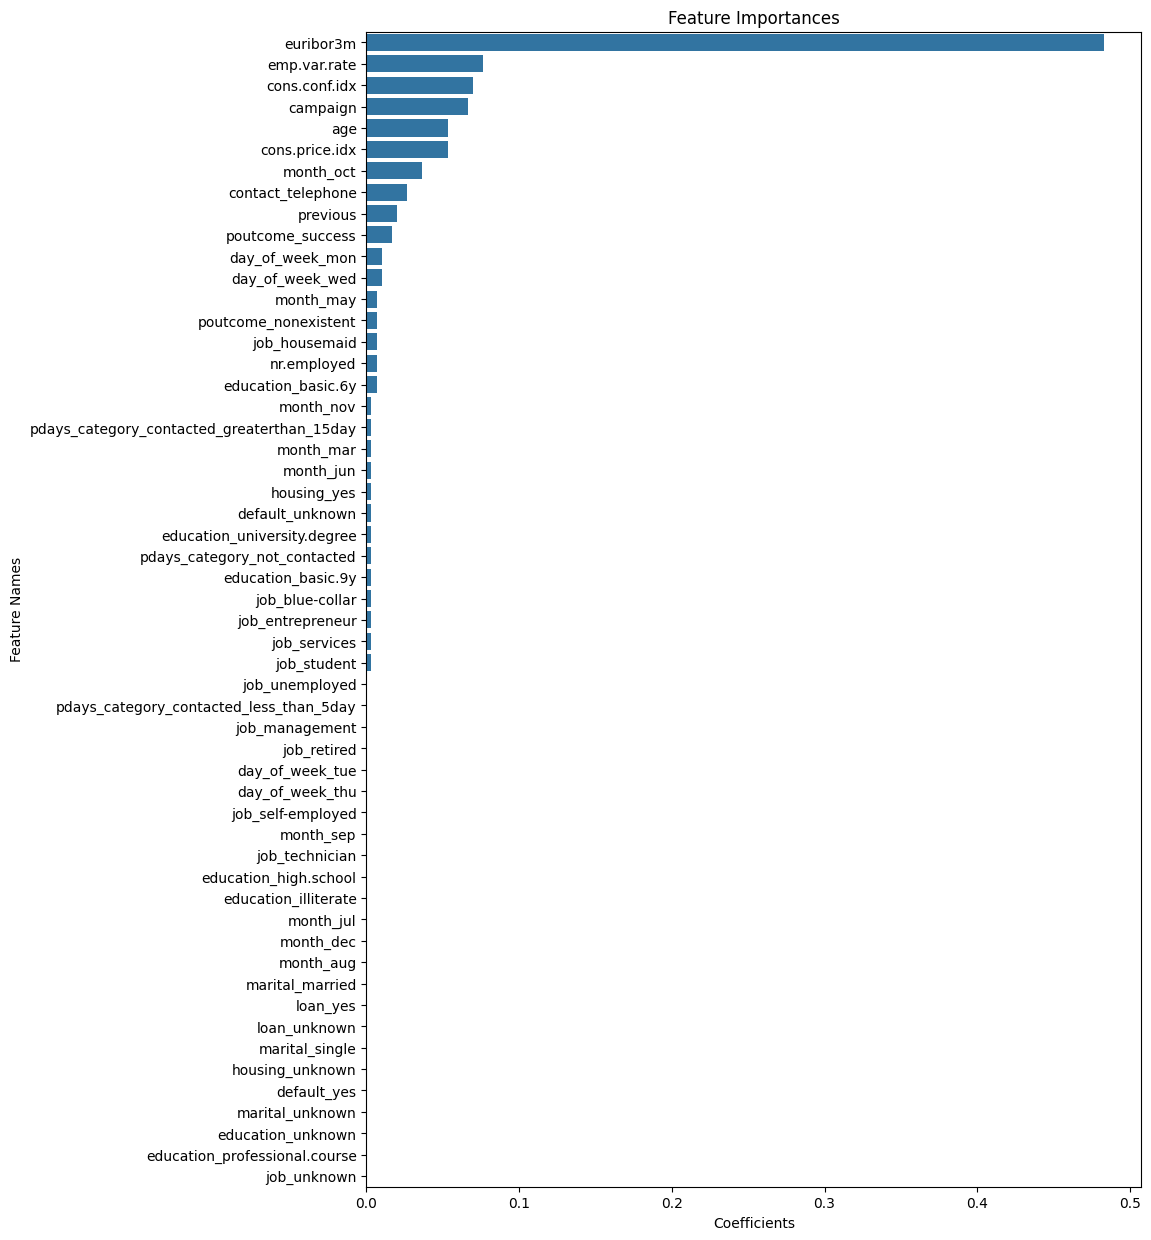

In [41]:
plotfeatureimportances(xtrain, importance)

## From the above diagram we can find the most important features that for prediction. 
## Drivers of conversion are:
    1. euribor3m
    2. emp.var.rate
    3. cons.conf.idx
    4. Campaign
    5. Age
    
## What your recommendation would be to cut the number of calls supposing that you get a 
## "test/prediction set" of new customers every week
    1. Use trained model and predict whether the new customer will buy or not. 
    2. Select the customers whose pobability of conversion is more
   ### This way bank can reduce the number of calls with out impacting the customer accusition.